# Выпускной проект. Тема: Банки - Анализ оттока клиентов

## Материалы: 
[Презентация и список пакетов](https://drive.google.com/drive/folders/1bchD7ALZ1gH-rwVjkq2CRgM-GRtvPQgJ?usp=drive_link)

<h2>Table of Contents</h2>

* [Загрузка данных](#data_load)
* [Предобработка данных](#preprocessing)
* [Исследовательский анализ данных](#eda)
* [Отличительные черты по группам](#features)
* [Проверка статистических гипотез](#stats_test)
    * [Гипотеза №1](#hypothesis_1)
    * [Гипотеза №2](#hypothesis_2)
    * [Гипотеза №3](#hypothesis_3)
    * [Гипотеза №4](#hypothesis_4)
* [Сегментация клиентов](#segmentation)
* [Рекомендации](#recommendations)
    * [Приоритизация групп](#prioritization)
    * [Решения](#solutions)
* [Декомпозиция проекта](#decomposition)

**Описание проекта:** банковская система функционирует на основе предоставления актуальных и целесообразных услуг своим клиентам. С этой точки зрения ключевой задачей банка является изучение клиентской базы и её предпочтений с целью максимизации своей прибыли и увеличения лояльности. На основе датасета регионального банка можно определить параметры, влияющие на отток клиентов, чтобы в дальнейшем корректировать пакеты предложений.

**Цель исследования:** изучить имеющиеся данные о клиентах банка и выявить основные причины оттока целевой аудитории, разделить клиентов на сегменты и проработать рекомендации по стратегии предоставления сфокусированных услуг на каждую страту.

<a id='data_load'></a>
## Загрузка данных

In [1]:
import os
import sys
os.environ['PYTHONEXECUTABLE'] = sys.executable

In [3]:
import numpy as np
import pandas as pd
from matplotlib import colormaps
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import scipy.stats as stats
# import plotly.express as exp
import math
#import statsmodels.api as sm

import statsmodels
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
import pingouin as pg

import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

In [4]:
try: 
    client_data = pd.read_csv('datasets/bank_scrooge.csv', sep=',')
except:
    client_data = pd.read_csv('https://code.s3.yandex.net/datasets/banks_scrooge.csv', sep=',')

<a class="anchor" id="preprocessing"></a>
## Предобработка данных

In [5]:
def general_info(**dfs):
    """Функция проверяет дубликаты в категориальных данных, 
               приводит типы, где возможно,
               выводит общую информацию
    
    **dfs - датафреймы к обработке
    """
    for name, df in dfs.items():
        df.columns = df.columns.str.lower()
        df.columns = df.columns.str.replace(' ', '_')
        
    #Ищем явные дубликаты
    duplicates = 0
    out = ''
    for col in df.columns:
        if "id" in col:
            duplicates = df[col].duplicated().sum()
            out = f'Дубликатов в столбце ключей \033[1m{col}\033[0m: {duplicates}'
    print('\033[1m' + 'Количество явных дубликатов:' + '\033[0m')
    for name, df in dfs.items():
        print('%-10s | %10d' % (name, duplicates + df.duplicated().sum()))
        if duplicates > 0: 
            print(out)
    print('\n\n')
    
    #Ищем неявные дубликаты
    for name, df in dfs.items():
        print('\033[1m' + 'Датафрейм {}: '.format(name) + '\033[0m')
        print('\033[1m' + 'Список уникальных значений для категориальных данных: ' + '\033[0m')
        for col in df.columns:
            if df[col].dtype != 'object':
                continue
            try:
                df[col] = df[col].astype('float64')
            except:
                try:
                    if col == 'dt':
                        df[col] = pd.to_datetime(df[col]).dt.date
                    else:    
                        df[col] = pd.to_datetime(df[col], format='%d-%m-%Y')
                except:
                    print('{}: {}'.format(col, df[col].unique()))
                    if len(df[col].unique()) > 5:
                        col_formatted = df[col].str.lower().replace(' ', '_').replace('-', '_').unique()
                        print('Наличие неявных дубликатов в {}: {}'
                              .format(col, not (len(col_formatted) == len(df[col].unique()))))
    print('\n\n')
    # Выводим преобразованные датафреймы
    print('\033[1m'+'Преобразованные датафреймы:' + '\033[0m')
    for name, df in dfs.items():
        print(df.info(memory_usage=False))
        print()

In [6]:
general_info(Клиенты=client_data)

Количество явных дубликатов:
Клиенты    |         73
Дубликатов в столбце ключей userid: 73



Датафрейм Клиенты: 
Список уникальных значений для категориальных данных: 
city: ['Рыбинск' 'Ярославль' 'Ростов']
gender: ['Ж' 'М']



Преобразованные датафреймы:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4)

Из приведённой выше информации заключаем:  
 - дубликаты в датафрейме найдены, они принадлежат столбцу userid.
 - на уровне строковых значений неявные дубликаты не просматриваются.
 - в данных есть пропуски в столбцах `age` и `balance`.

Рассмотрим дублированные строки по `userid` более детально, чтобы определить дальнейшие действия.

In [7]:
display(pd.concat(g for _, g in client_data.groupby("userid") if len(g) > 1))

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4216,226719,903.0,Рыбинск,Ж,63.0,0,NaN,1,1,0,138582.58,0
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0


Из представленной таблицы можно сделать вывод, что причиной дублирования является переезд со сменой личной информации. Проверим эту гипотезу.

In [8]:
moved_info = client_data.groupby('userid').agg({'city': 'nunique'})
moved_info = moved_info.query('city > 1')
print(len(moved_info))

73


Записей с различающимися городами на одного клиента столько же, сколько всего дубликатов в данных. Это подтверждает, что повторная запись происходит при смене города.  
Повторное внесение излишне для базы клиентов, особенно если устаревшие данные нигде не используются. Поэтому дубликаты следует удалить, оставив лишь последние записи. Ориентироваться будем на столбец возраста. Если где-то информация пропущена, оставляем более полную запись.

In [9]:
client_data = (client_data
    .sort_values(by=['userid','age'], ascending=True)
    .dropna(subset=['age'])
    .drop_duplicates(subset=['userid'], keep='last')
)
print('Размер оставшейся базы: {}'.format(len(client_data)))

Размер оставшейся базы: 9924


После обработки дубликатов приступаем к работе с пропусками. Рассмотрим пропуски в `age` и `balance`:  

In [10]:
print('Пропуски в\033[1m age \033[0m: {}'.format(client_data['age'].isna().sum()))
print('Пропуски в\033[1m balance \033[0m: {}'.format(client_data['balance'].isna().sum()))

Пропуски в age : 0
Пропуски в balance : 2270


Все пропуски в `age` ликвидированы, это значит, что они были связаны исключительно с дублями в идентификаторах, и мы намеренно их убрали.

Пропуски в `balance`, однако, составляют более 20% записей. Клиссифицируем их. Поскольку данные для банковской базы собираются автоматически на основе электронных профилей, вариант с MCAR отбрасывается. В данном случае либо существует связь между имеющимися признаками и балансом, либо была допущена ошибка при сборе, что предполагает наличие неизвестного фактора, повлиявшего на пропуски. В обоих случаях в имеет смысл использовать метод заполнения MICE (Метод многомерных цепных уравнений). Он позволяет достичь большей эффективности, чем простые методы вменения, не теряя при этом данные.

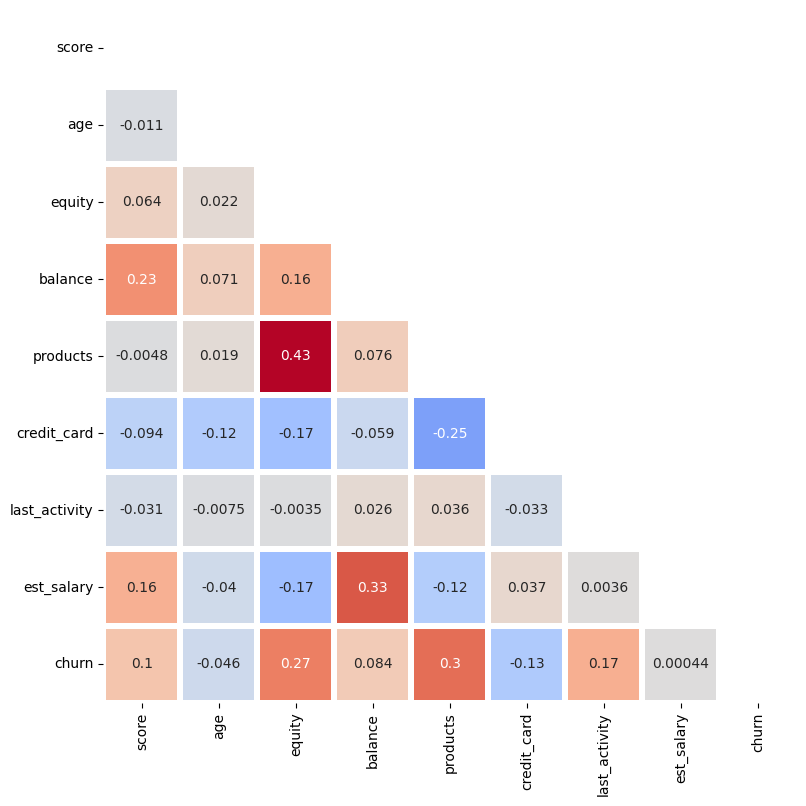

In [11]:
new = client_data.drop(columns=['userid', 'city', 'gender'])
plt.subplots(figsize=(9, 9))
mask = np.triu(np.ones_like(new.corr()))
sns.heatmap(new.corr(),
            mask=mask,
            cmap='coolwarm',
            cbar=False,
            square=True,
            annot=True,
            center=0,
            linewidths=3);

По тепловой карте корреляции видно, что с балансом из всех представленных переменных наиболее связаны score и est_salary. Будем строить регрессионную модель для заполнения по ним.

In [12]:
# Оставляем только список входных атрибутов и зависимых данных для модели
train_data = new[['balance', 'score', 'est_salary']]
# Создаем объект, включащий описание модели заполнения
iimp = IterativeImputer(
    estimator=BayesianRidge(),
    tol=1e-4,
    random_state=0,
)
# Тренируем модель
final = iimp.fit_transform(train_data)
imputed_data = pd.DataFrame(final, columns=train_data.columns)

# Вставляем пропуски в данных
client_data['balance'] = imputed_data['balance']
print(client_data.isna().sum())

userid            0
score             0
city              0
gender            0
age               0
equity            0
balance          76
products          0
credit_card       0
last_activity     0
est_salary        0
churn             0
dtype: int64


После проделанной операции в balance осталось всего 76 пропусков. Поскольку для них модель не подобрала связанных значений и количество мало (менее 1% данных), можем удалить эти записи.

In [13]:
client_data.dropna(subset='balance', inplace=True)
client_data.drop(columns='userid', inplace=True)
client_data.reset_index(drop=True, inplace=True)

**Вывод:** в результате данного шага была проведена работа по удалению дубликатов из столбца userid. Также строки с пропусками в значении баланса были обработаны с помощью метода множественной импутации, предполагающим обучение модели для наиболее точного заполнения пропусков. Баланс не может быть заполнен случайным или средним значением, поскольку такая ошибка может стоить неправильно интерпретированной оценки корреляции с остальными данными.

<a class="anchor" id="eda"></a>
## Исследовательский анализ данных

Матрица корреляций, использующая коэффициент Пирсона, в данном случае не даёт точной картины корреляции, поскольку указанный коэффициент применим для непрерывных значений с нормальным распределением. Нас интересует оценка связи между категориальными и дискретными значениями в том числе, поэтому используем phik коеффициент:

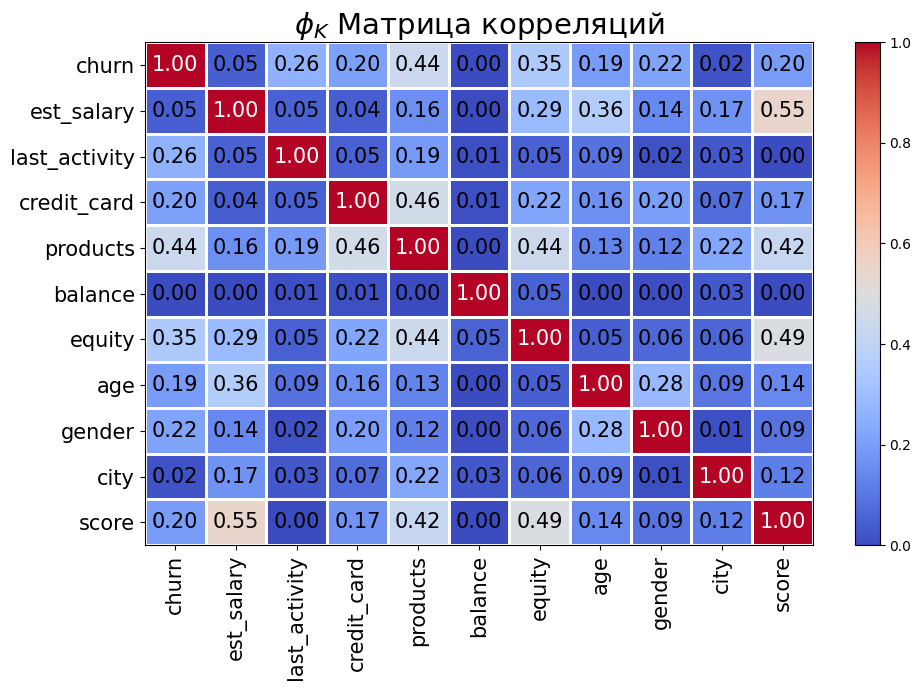

In [14]:
data_types = {
    'age': 'interval',
    'equity': 'interval',
    'balance': 'interval',
    'products': 'interval',
    'score': 'ordinal',
    'credit_card': 'categorical',
    'last_activity': 'categorical',
    'est_salary': 'interval',
    'churn': 'categorical',
}

interval_cols = [col for col, v in data_types.items() if v=='interval' and col in client_data.columns]

phik_overview = client_data.phik_matrix(interval_cols=interval_cols)

cm = colormaps['coolwarm']
plot_correlation_matrix(
    phik_overview.values, x_labels= phik_overview.columns,
    y_labels = phik_overview.index, vmin=0, vmax=1,
    title=r"$\phi_K$ Матрица корреляций",
    fontsize_factor=1.5, figsize=(10,7),
    color_map=cm)
# display(phik_overview.style.format(precision=3, na_rep='-')
#         .background_gradient(cmap=cm)
#        )

Судя по общепринятой шкале корреляции Чеддока, единственная связь, которая подходит под понятие "средняя", т.е. является достаточной, в массиве данных прослеживается в паре: **`score`** - **`est_salary`**.
Тем не менее, можно глубже рассмотреть связки **`products`** - **`equity`**, **`products`** - **`credit_card`**, поскольку они также выраженны, и корреляция products с **`churn`** выше остальных переменных. А **`churn`** нас интересует как целевая метрика.

Рассмотрим каждый признак в его распределении, чтобы подробнее понять картину.

In [15]:
import matplotlib.patches as patches
import matplotlib.lines as lines
    
def make_labels(ax, boxplot):
    iqr = boxplot['boxes'][0]
    caps = boxplot['caps']
    med = boxplot['medians'][0]
    fly = boxplot['fliers'][0]
    
    xpos = med.get_xdata()
    ypos = med.get_ydata()
    
    xlabel = xpos[1]
    ylabel = ypos[1]

    offset = ylabel - 0.3 * ax.get_position().height
    pc25 = iqr.get_xdata().min()
    pc75 = iqr.get_xdata().max()

    capleft = caps[0].get_xdata()[0]
    capright = caps[1].get_xdata()[0]
    
    props = {
        'family': 'sans-serif',  
        'weight': 'semibold',   
        'size': 14,
        'color': 'blue',
        'ha': 'center',
        'va': 'center',
        'rotation': 270,
    }
    ax.text(xlabel, offset,
            '{:6.3g}'.format(xlabel), **props)
    ax.text(pc25, offset,
            '{:6.3g}'.format(pc25), **props)
    ax.text(pc75, offset,
            '{:6.3g}'.format(pc75), **props)
    props1 = props.copy()
    props1.update({'color': 'gray', 'size': 12})
    ax.text(capleft, offset,
            '{:6.3g}'.format(capleft), **props1)
    ax.text(capright, offset,
            '{:6.3g}'.format(capright), **props1)

In [16]:
class PlotAttr:
    source = None
    '''
    Класс для представления типов графиков
    
    ...
    
    Атрибуты:
    ---------
    key: pd.Series
        колонка для рисования графика
    value: list
        название графиков, которые нужно отрисовать
    '''
    def __init__(self, attributes):
        self.n_rows = 1
        self.n_cols = 1
        self.shared_title = ''
        self.dynamic_attrs = []

        self.titles = []
        for key, value in attributes.items():
            setattr(self, key, value)
            self.dynamic_attrs.append(key)
            self.n_cols = max(self.n_cols, len(value))
        self.n_rows = len(attributes.items())
        
        
    
    def draw(self):
        fig, axes = plt.subplots(self.n_rows, self.n_cols, figsize=(15, 4 * self.n_rows), constrained_layout=True)
        fig.suptitle(self.shared_title, fontsize=18)
        axes = np.atleast_2d(axes)
        for row, key in enumerate(self.dynamic_attrs):
            plot_types = self.__dict__[key]
            data = self.source[key]
            filtered = data[(data <= np.percentile(data, 95))]
            for i in range(len(plot_types)):
                if plot_types[i].startswith('box'):
                    self.boxplot(axes, filtered, row, i, self.titles[row])
                elif plot_types[i].startswith('kde'):
                    self.kdeplot(axes, filtered, row, i, self.titles[row])
                elif plot_types[i].startswith('hist'):
                    self.histplot(axes, filtered, row, i, self.titles[row])
        plt.show()
                
    
    def __repr__(self):
        return f"PlotAttr({', '.join(f'{key}={value}' for key, value in self.__dict__.items())})"
    
    
    def boxplot(self, axes, key, row_number, col_number, title):
        '''
         Рисует графики boxplot,
         применяемые постолбчато

         Параметры:
             key: столбец для графика
             col_number: номер столбца в общем графике
             title: название столбца, легенда диаграммы
        '''
        subplot = axes[row_number, col_number].boxplot(x=key, vert=False)
        axes[row_number, col_number].xaxis.grid(True)
        axes[row_number, col_number].set_xlabel(f'{title}', fontsize=12)
        make_labels(axes[row_number, col_number], subplot)
#         sns.despine(trim=True, left=True)
        
    def kdeplot(self, axes, key, row_number, col_number, title):
        subplot = sns.kdeplot(data=key, ax=axes[row_number, col_number])
        axes[row_number, col_number].set(title=title, ylabel='Плотность вероятности')
        
    def histplot(self, axes, key, row_number, col_number, title):
        subplot = sns.histplot(data=key, kde=True, ax=axes[row_number, col_number])
        axes[row_number, col_number].set(title=title, ylabel='Количество записей')
#     def correlogram(self, axes, data, row_number, col_number, title):

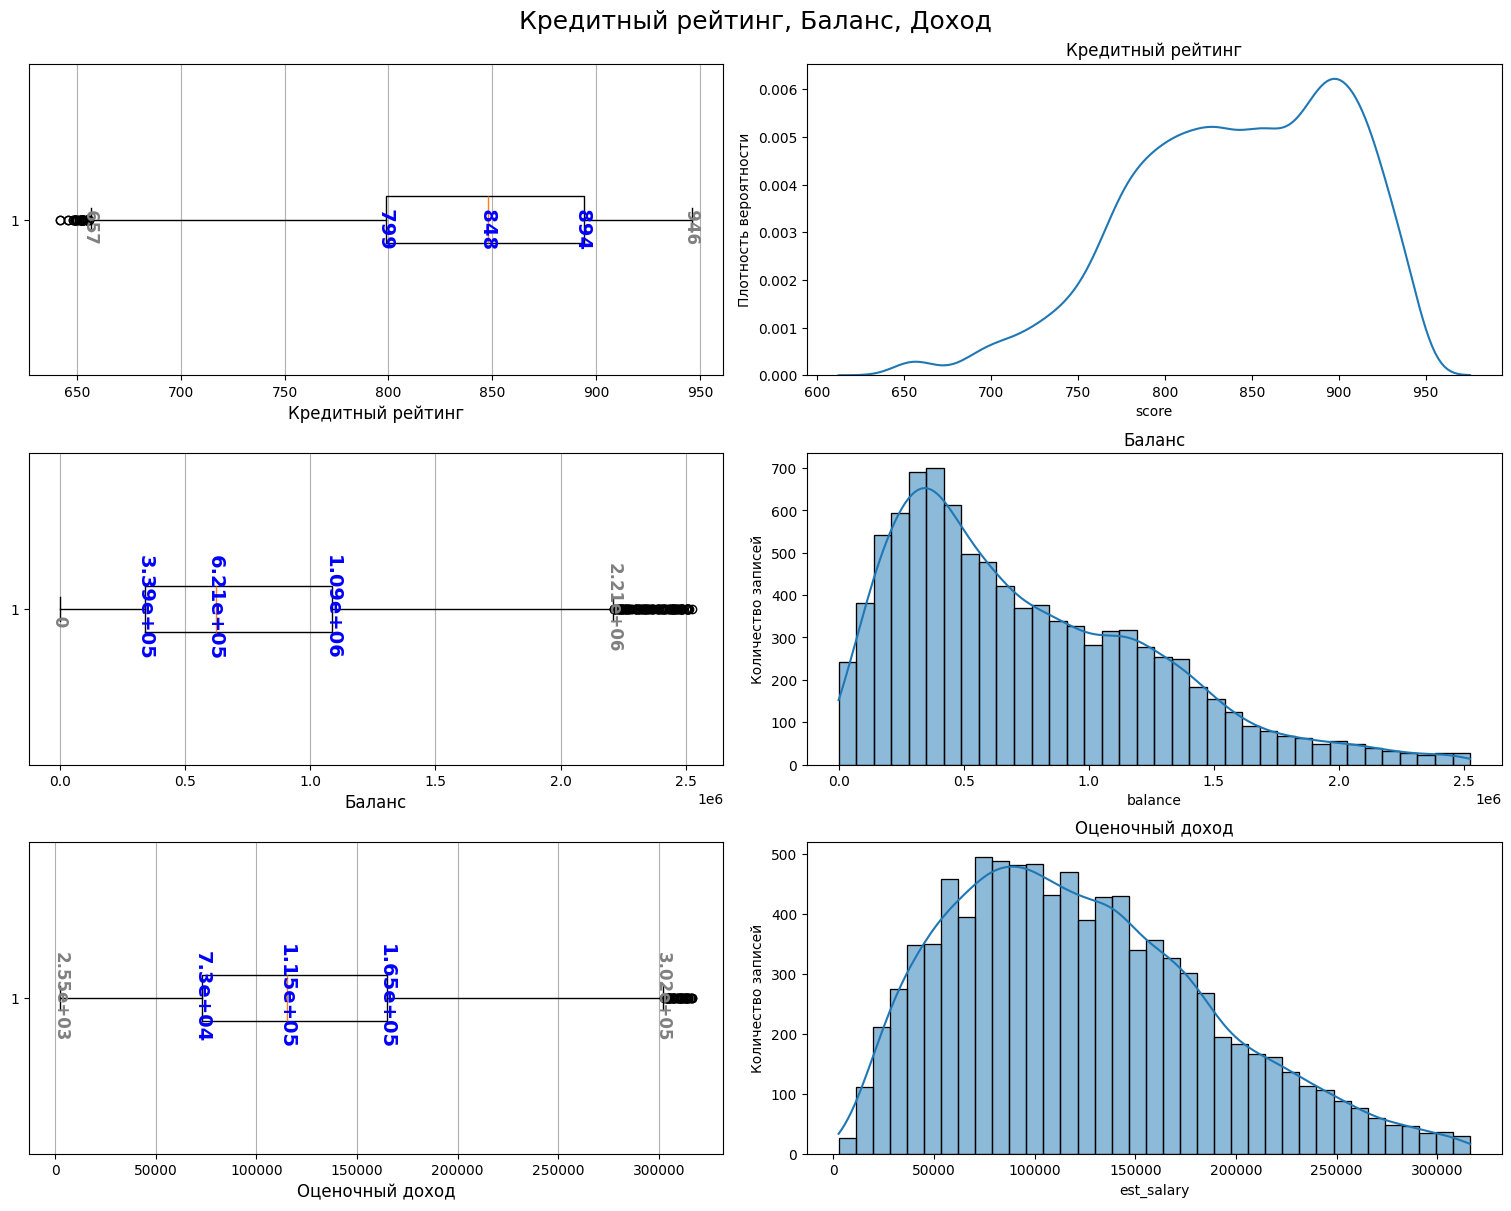

In [17]:
PlotAttr.source = client_data
plot_1 = PlotAttr({'score': ['boxplot', 'kdeplot'],
                 'balance': ['boxplot', 'histplot'],
                 'est_salary': ['boxplot', 'histplot']})
plot_1.shared_title = 'Кредитный рейтинг, Баланс, Доход'
plot_1.titles = ['Кредитный рейтинг', 'Баланс', 'Оценочный доход']
plot_1.draw()

По графикам можно установить, что кредитный рейтинг варьируется в основном в диапазоне 800-900 с медианой на 850, однако сам диапазон определяется границами ~650 и 1000. 
Что касается баланса, мода распределения близка к 450 тыс. руб., большая доля клиентов имеет на счету от 100 до 650 тыс., если смотреть на медианное значение, то оно будет чуть выше 620 тыс. руб., поскольку распределение имеет высокую плотность вначале и длинный хвост в конце. Интересно, что квантили распределения задают границы в 339 и 1009 тыс. соответственно.
По зарплате медиана равна 115 тыс. руб., 25% попадают в диапазон 73-115 тыс., ещё 25% - в диапазон 115-165 тыс. руб.

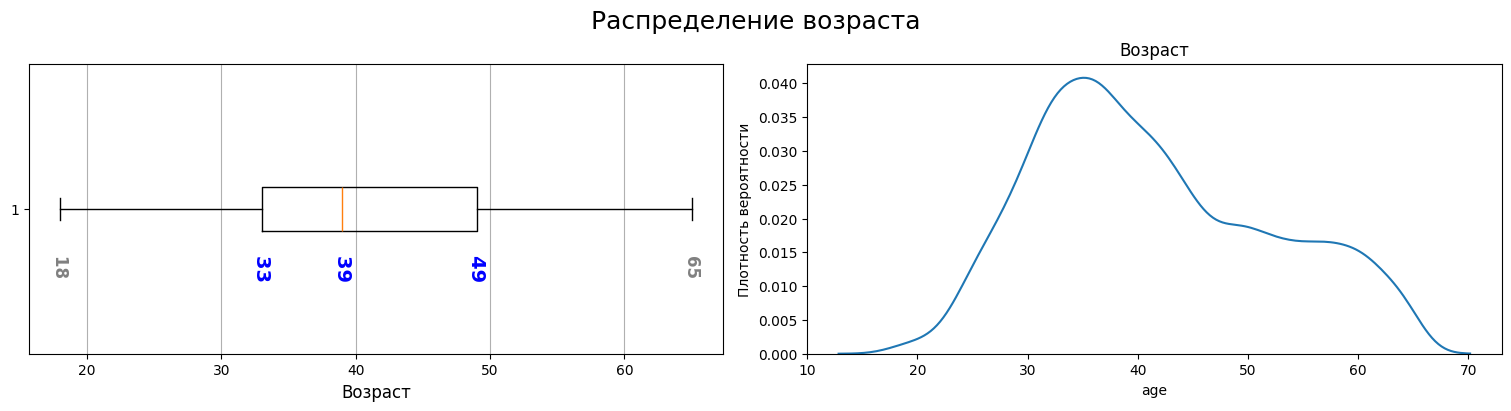

In [18]:
plot_2 = PlotAttr({'age': ['boxplot', 'kdeplot']})
plot_2.shared_title = 'Распределение возраста'
plot_2.titles=['Возраст']
plot_2.draw()

Возраст зарегестрированных лиц имеет достаточно широкую вариативность - частотность встречаемости от 26 до 60 велика. Основной целевой группой являются акторы в возрасте от 33 до 49 лет.

Соотношение клиентов в разрезе оттока: 
лояльные - 81.996%
отточные - 18.004%


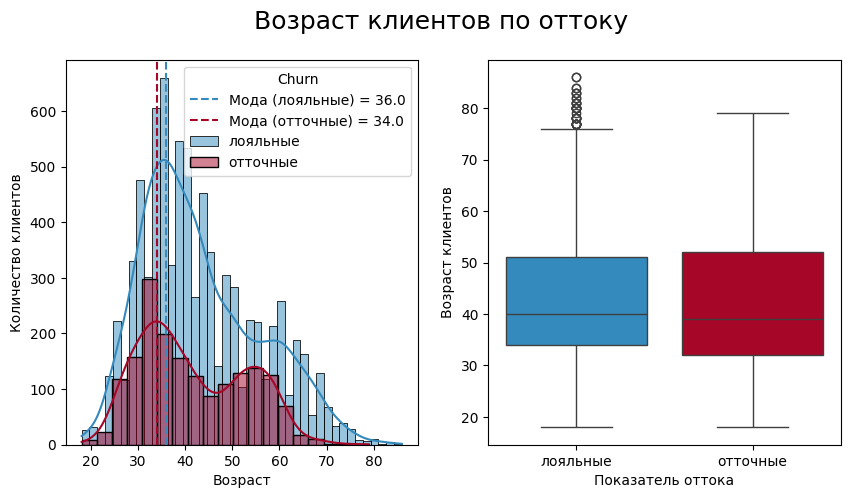

In [19]:
label_map = {0: 'лояльные', 1: 'отточные'}
ax = None
colors = ['#348ABD', '#A60628']
# for patch in plot[0].patches:
#     facecolor = patch.get_facecolor()
#     if facecolor not in colors:
#         colors.append(facecolor)

print("\033[1mСоотношение клиентов в разрезе оттока: \033[0m")
for churn_value, group in client_data.groupby('churn'):
    print(f"\033[1m{label_map[churn_value]}\033[0m - {(len(group) / len(client_data) * 100):.3f}%")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Возраст клиентов по оттоку", fontsize=18)

for churn_value, group in client_data.groupby('churn'):
    sns.histplot(group.age, ax=axes[0], kde=True, color=colors[churn_value], label=label_map[churn_value], alpha=0.5)
    mode_result = stats.mode(group.age)
    mode_value = mode_result.mode
    axes[0].axvline(mode_value, color=colors[churn_value], linestyle='--', label=f'Мода ({label_map[churn_value]}) = {mode_value}')

axes[0].legend(title="Churn")
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Количество клиентов')

bplot = sns.boxplot(x='churn', y='age', data=client_data, ax=axes[1])
for patch, color in zip(bplot.patches, colors):
    patch.set_facecolor(color)
ticks = axes[1].get_xticks()
axes[1].set_xticks(ticks)
axes[1].set_xticklabels([label_map.get(int(x), x) for x in ticks])
axes[1].set(xlabel='Показатель оттока', ylabel='Возраст клиентов')
plt.show()

Во-первых, видно, что форма распределений в целом похожа, но диапазон значений несколько меньше для возрастов отточных клиентов. Мода для лояльных клиентов - 36 лет, отточных - 34 года. Квантили аналогичны. В целом единственное значимое различие - размеры выборок. Убеждаемся в отсутствии связи возраста клиентской базы с отточностью.

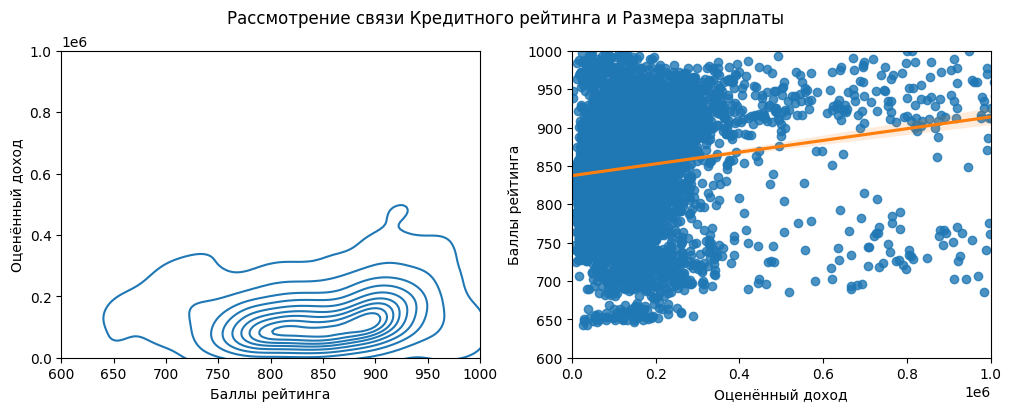

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
fig.suptitle('Рассмотрение связи Кредитного рейтинга и Размера зарплаты')
p1 = sns.kdeplot(data=client_data, x='score', y='est_salary', ax=ax[0])
p1.set(ylim=[0, 1e6], xlim=[600, 1000], xlabel='Баллы рейтинга', ylabel='Оценённый доход')
p2 = sns.regplot(x='est_salary', y='score', data=client_data, line_kws={"color": "C1"}, ax=ax[1])
p2.set(xlim=[0, 1e6], ylim=[600, 1000], ylabel='Баллы рейтинга', xlabel='Оценённый доход')
plt.show()

По графику ясно, что корреляция между оценкой заработной платы и балансом на счёте очень незначительна. Коэффициент Пирсона показал значение 0.33, что свидетельствует о слабой связи. Была произведена попытка найти модель, объясняющую изменчивость; в частности линейная, гиперболическая регрессия, метод дерева решений. Однако ни одна модель при оценке качества (R^2, RMSE) не дала значимый результат. Прямая причинно-следственная связь отсутствует, возможна лишь сложная косвенная зависимость, перекрываемая шумом в данных. 

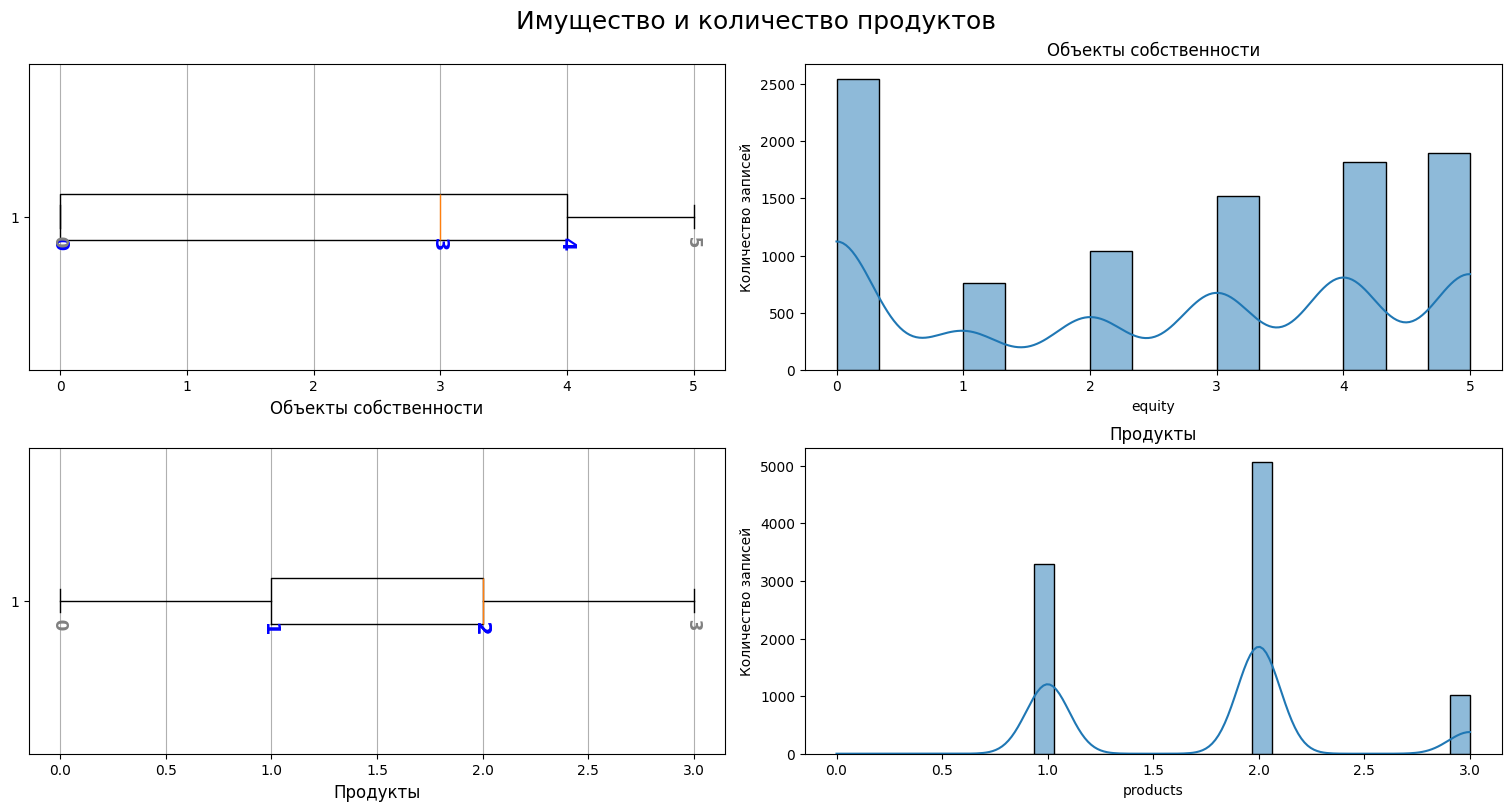

In [21]:
equity_prod = PlotAttr({client_data['equity'].name: ['boxplot', 'histplot'], client_data['products'].name: ['boxplot', 'histplot']})
equity_prod.shared_title = 'Имущество и количество продуктов'
equity_prod.titles = ['Объекты собственности', 'Продукты']
equity_prod.draw()

In [22]:
import plotly.express as px

In [23]:
import plotly.io as pio
pio.renderers.default = 'iframe'

client_data['eq-pr'] = client_data.groupby(['equity', 'products'])['products'].transform(len)
f = px.scatter(client_data, x='equity', y='products', size='eq-pr')
f.show()
client_data.drop(columns=['eq-pr'], inplace=True)

In [24]:
from scipy.stats import spearmanr
res = spearmanr(client_data['products'], client_data['equity'])
print(f"Коэф. Спирмена: {res.statistic}, p-значение: {res.pvalue}")

Коэф. Спирмена: 0.4552524817485637, p-значение: 0.0


Для параметров баллов собственности и количества продуктов был построен график, показывающий количество клиентов в каждой группе. Мы видим, что значительная часть клиентов - около 20% - не имеет имущества и пользуется одним продуктом банка. При увеличении количества продуктов наблюдается рост размеров групп монотонно с ростом баллов собственности. На это и указывает коэффициент Спирмена, выдавая значение **r=0.456**, что интерпретируется как умеренная положительная связь между этими величинами.

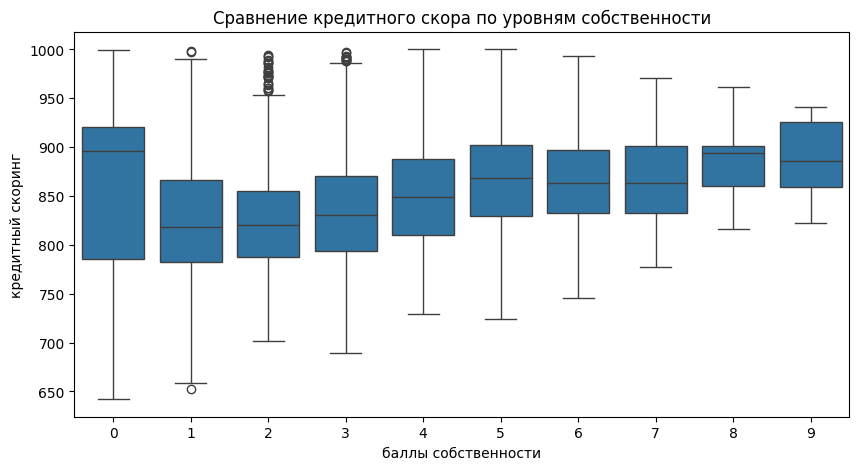

In [25]:
from scipy.stats import chi2_contingency, kendalltau, shapiro
from scikit_posthocs import posthoc_dunn
import pingouin as pg

plt.figure(figsize=(10, 5))
box = sns.boxplot(x='equity', y='score', data=client_data)
plt.title('Сравнение кредитного скора по уровням собственности')
plt.xlabel("баллы собственности")
plt.ylabel("кредитный скоринг")
plt.show()

In [26]:
# print(pg.welch_anova(dv='score', between='equity', data=client_data))
grouped_data = [group['score'].values for _, group in client_data.groupby('equity')]
print(stats.kruskal(*grouped_data))

print()
posthoc = posthoc_dunn(client_data, val_col='score', group_col='equity', p_adjust='bonferroni')
print("\nPost-hoc Dunn's test:")
print(posthoc <= 0.05)
# post_hoc = pg.pairwise_gameshowell(data=client_data, dv='score', between='equity').round(3)
# print(post_hoc.query('pval <= 0.05'))

KruskalResult(statistic=np.float64(759.0616673995215), pvalue=np.float64(1.3727346597919587e-157))


Post-hoc Dunn's test:
       0      1      2      3      4      5      6      7      8      9
0  False   True   True   True   True  False  False  False  False  False
1   True  False  False  False   True   True   True   True   True   True
2   True  False  False   True   True   True   True   True   True   True
3   True  False   True  False   True   True   True   True   True   True
4   True   True   True   True  False   True  False  False  False  False
5  False   True   True   True   True  False  False  False  False  False
6  False   True   True   True  False  False  False  False  False  False
7  False   True   True   True  False  False  False  False  False  False
8  False   True   True   True  False  False  False  False  False  False
9  False   True   True   True  False  False  False  False  False  False


При рассмотрении кредитного рейтинга в разрезе количества недвижимости клиентов, видно интересное распределение: клиенты с самым высоким рейтингом не обладают недвижимостью вообще. Это объясняется тем, что они не использовали потенциал своих средств на погашение кредитов. Самый низкий крединтый скоринг характерен для заёмщиков с 1 или 2 единицами собственности. Для более информативного анализа используем односторонний дисперсионный анализ. 
Он показал, что различия, которые мы видим на графике, статистически значимы. Чтобы посмотреть, где конкретно разница существенна, используем post-hoc тест Games-Howell. P-value показал, что между собой схожи рейтинги заемщиков с 1, 2 и 3 объектами недвижимости. Другая группа, в которой медианный рейтинг между собой различается несущественно, это 0, а также 5-9 объектов. 
1-3 балла - низкий уровень собственности. Заёмщик владеет недостаточным количеством имущества или его активы не являются весьма стабильными (например, арендуемое жильё или владение только малой долей недвижимости). Такие заёмщики, скорее всего, воспринимаются как более рискованные, потому что не имеют финансовой подушки.
Владельцы же недвижимости с большим количеством активов могут использовать эти активы в качестве залога, что снижает риск невыполнения обязательств.

В целом связь есть, но она нелинейна и скорее косвенна, поскольку в формировании кредитного скоринга участвуют многие переменные.

In [27]:
from sklearn.preprocessing import StandardScaler
subset = client_data.drop(columns=['city', 'gender'])
X = subset.values[:,1:-1]
X = np.nan_to_num(X)
clus_dataset = StandardScaler().fit_transform(X)

In [28]:
X = clus_dataset
k = 4

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

linked = linkage(X, method = 'ward')
clusters = fcluster(linked, 4, criterion='maxclust')
subset['aggl_clusters'] = clusters
groups, counts = np.unique(clusters, return_counts=True)
for key in groups:
    print(f"{key}: {counts[key-1]}")

1: 2969
2: 279
3: 2842
4: 3758


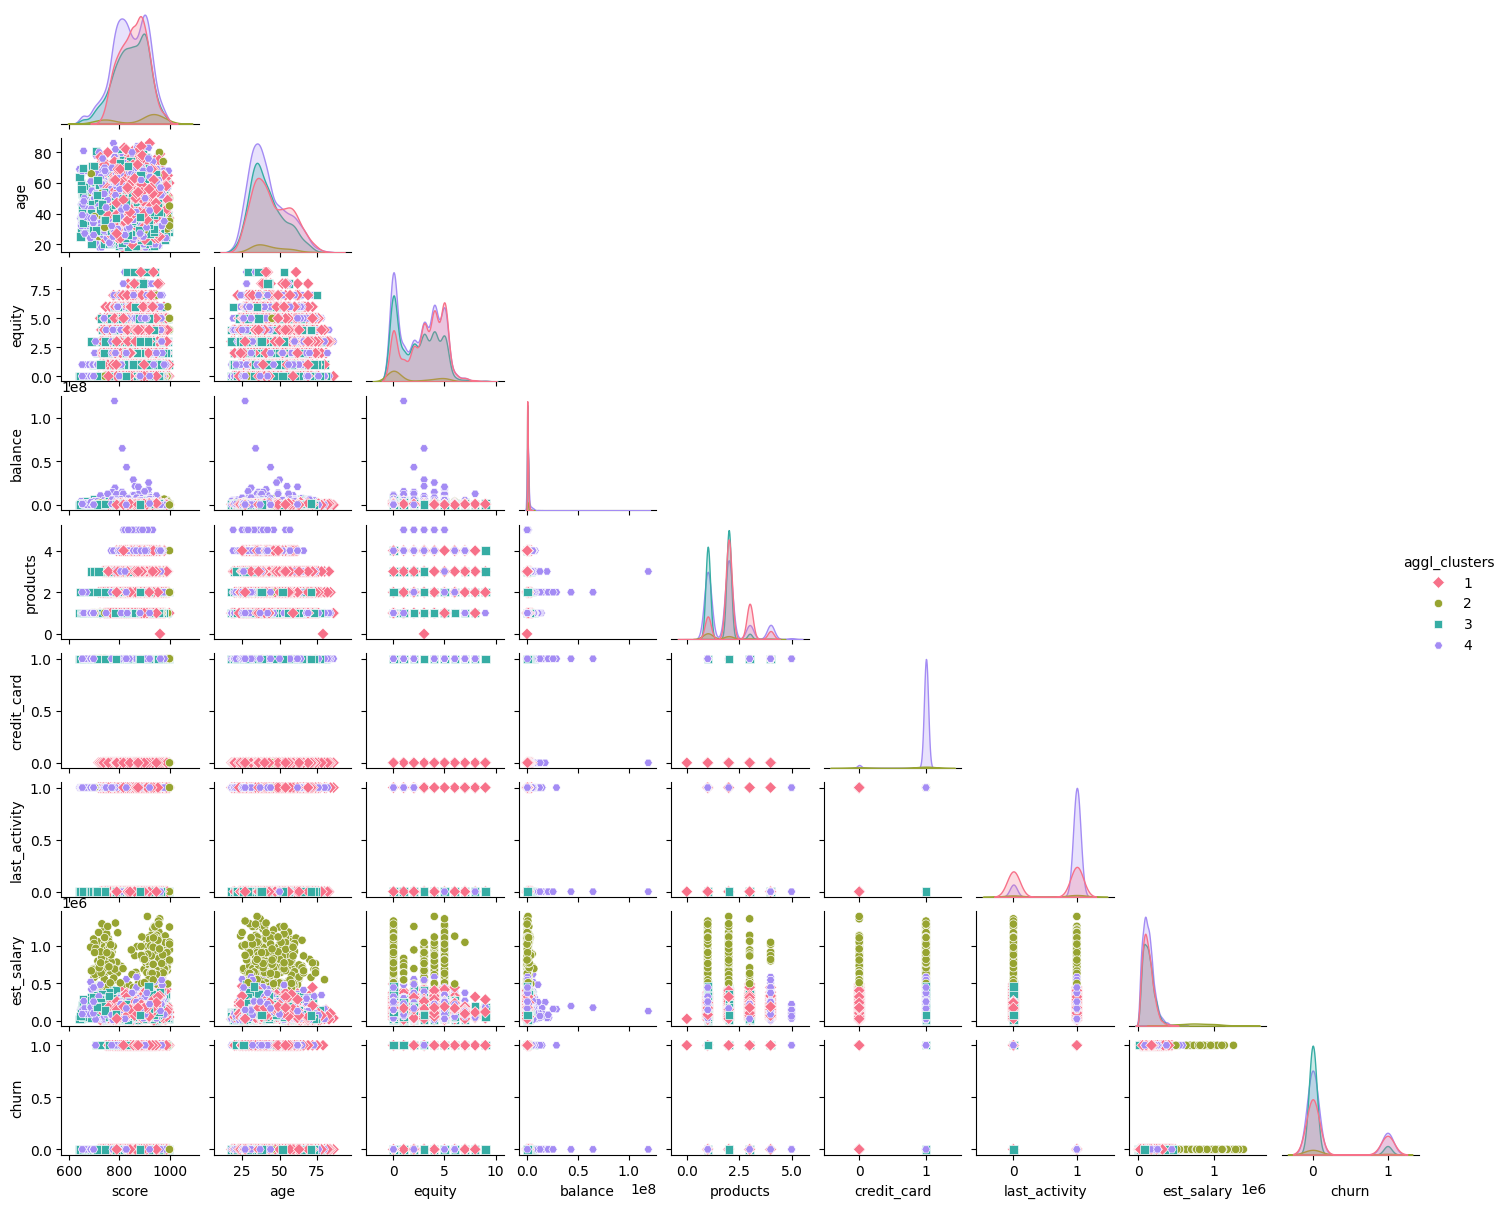

In [29]:
g = sns.pairplot(subset, hue='aggl_clusters', palette=sns.color_palette("husl", 4), corner=True, markers=["D", "o", "s", "H"])
g.fig.set_figheight(12)
g.fig.set_figwidth(15)
plt.show()

Выше была выполнена кластеризация на 4 группы (количество признано оптимальным после рассмотрения дендрограммы возможных разделений). Первые строки отражают размеры каждого кластера.

Далее рассмотрим средние и медианы различных факторов по кластерам отдельно:

In [30]:
subset['churn'] = client_data['churn']
subset.groupby('aggl_clusters').mean()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
aggl_clusters,,,,,,,,,
1,855.873021,44.912092,3.116538,7.887979e+05,2.173122,0.000000,0.540586,125825.484796,0.253621
2,878.641577,43.831541,1.451613,8.429448e+05,1.505376,0.727599,0.566308,804341.285591,0.136201
3,846.158339,41.613652,2.339198,7.912429e+05,1.581281,1.000000,0.000000,130691.214968,0.073188
4,842.639702,41.866152,2.553752,1.266887e+06,1.873869,0.973124,0.898350,129467.999524,0.205961


In [31]:
subset.groupby('aggl_clusters').median()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
aggl_clusters,,,,,,,,,
1,858.0,43.0,3.0,637713.860,2.0,0.0,1.0,114804.27,0.0
2,920.0,41.0,0.0,655604.580,1.0,1.0,1.0,792520.46,0.0
3,852.0,39.0,2.0,635067.015,2.0,1.0,0.0,120015.86,0.0
4,843.0,39.0,3.0,708975.020,2.0,1.0,1.0,116717.24,0.0


Применив агломеративную кластеризацию данных по всем метрикам (за искл. пола и города), мы получили наглядную и интерпретируемую картину, отражающую портреты групп клиентов банка, по которым можно делать дальнейшие выводы.


### Отличительные черты по группам:  
**Кластер 1:** Cредний балл собственности наиболее высокий, отсутствие кредита. Процент оттока выше, чем усреднённый по всем клиентам.  
**Кластер 2:** Очень высокая оценённая зарплата. Балл собственности 0-1, продуктов 1. Самый высокий рейтинг. Низкий отток.  
**Кластер 3:** Наличие кредита, 0 активность в наблюдаемый период. ~2 балла собственности. Минимальный отток.  
**Кластер 4:** Много продуктов, высокий баланс на счёте. Открыт кредит, но кредитный скор небольшой. Отток средний.

<a class="anchor" id="stats_test"></a>
## Проверка статистических гипотез

<a class="anchor" id="hypothesis_1"></a>
### Гипотеза №1: 
**H0:** Между группами отточных и лояльных клиентов нет значимых различий в уровне дохода  
**H1:** Существует значительная разница в доходе отточных и лояльных клиентов  

Условия применения t-test для независимых выборок:
 1. Данные в обеих выборках должны приблизительно следовать нормальному распределению.
 2. Дисперсии (разброс значений) в двух выборках должны быть примерно одинаковыми.

Однако оба эти условия выполняются для данных выборок с учётом допущений. Во-первых, размер каждой выборки исчисляется тысячами, значит,   
по ЦПТ условие 1 можно опустить. Во-вторых, при задании параметра equal_var=False мы избавляемся от строгости условия 2.

In [32]:
df = subset[(subset['est_salary'] <= np.percentile(subset['est_salary'], 95))]
group1 = df[df.churn == 1].est_salary
group2 = df[df.churn == 0].est_salary

res = stats.ttest_ind(group1, group2, equal_var=False)
print('\033[1m' + 'Результат t-test:' + '\033[0m')
print(f'p-значение для двустороннего теста: {res.pvalue:.4f}')

Результат t-test:
p-значение для двустороннего теста: 0.0001


Проведение t-testа показало, что нулевая гипотеза отвергается. Однако мы сделаем ещё одну проверку с помощью непараметрического метода.

Основные допущения для проведения **U-теста Манна-Уитни**:  
    1. наблюдения в обеих выборках независимы  
    2. тип данных является как минимум ранговым, т. е. в отношении любых двух наблюдений можно сказать, какое из них больше  
  
Тест не требует определённого вида распределения и в этом смысле менее строг, однако отвечает не на вопрос о средних значениях, а о степени смещения одного диапазона - группы 1 - относительно другого - группы 2.

In [33]:
print('\033[1m' + 'Проверка различия в существенности различия значений дохода клиентов по оттоку. Группы churn=0/churn=1: ' + '\033[0m')
U, p = stats.mannwhitneyu(group1, group2)
print(f"Результаты Манна-Уитни: U = {U:.3f}, p = {p:.3f}")
print("Относительное различие: {0:.3f}".format(group1.median() / group2.median() - 1))
print()

Проверка различия в существенности различия значений дохода клиентов по оттоку. Группы churn=0/churn=1: 
Результаты Манна-Уитни: U = 6928439.000, p = 0.000
Относительное различие: 0.070



U-критерий показал аналогичное p-value, но при рассмотрении относительного различия медиан разница составляет всего 7%, что незначительно. Статистическая значимость, полученная в этом случае, не имеет практического значения. Проверим тест r-бенчмаркингом:

r-метрика Манна-Уитни ≈ 0.035 → Эффект крайне мал (далеко меньше порога 0.1 для слабого эффекта).

Проблема кроется, вероятно, в размере выборок. Размер исчисляется тысячами, поэтому любое отклонение видится значимым. Для верности применим бутстрап, применив ttest 1000 раз на равных по размеру выборках:

In [34]:
def bootstrap_ttest(group1, group2, n_iterations=1000):
    t_stats = []
    p_values = []
    
    for _ in range(n_iterations):
        sample1 = np.random.choice(group1, size=1000, replace=True)
        sample2 = np.random.choice(group2, size=1000, replace=True)
        
        t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
        t_stats.append(t_stat)
        p_values.append(p_val)
    
    t_stats = np.array(t_stats)
    p_values = np.array(p_values)
    
    t_stat_ci = np.percentile(t_stats, [2.5, 97.5])
    p_val_ci = np.percentile(p_values, [2.5, 97.5])
    
    return t_stats.mean(), p_values.mean(), t_stat_ci, p_val_ci

mean_t_stat, mean_p_val, t_stat_ci, p_val_ci = bootstrap_ttest(group1, group2)

print(f"Среднее значение t-статистики: {mean_t_stat:.3f}")
print(f"Среднее значение p-value: {mean_p_val:.3f}")
print(f"95% доверительный интервал для t-статистики: {np.round(t_stat_ci, 3)}")
print(f"95% доверительный интервал для p-value: {np.round(p_val_ci, 3)}")

Среднее значение t-статистики: 2.199
Среднее значение p-value: 0.113
95% доверительный интервал для t-статистики: [0.264 4.059]
95% доверительный интервал для p-value: [0.    0.772]


После проверки получили p-value ~0.1, что не позволяет отвергнуть нулевую гипотезу отсутствия различий между группами по доходу. 

<a class="anchor" id="hypothesis_2"></a>
### Гипотеза №2:
**H0:** Кредитный скор для клиентов всех кластеров одинаков.  
**H1:** Существует значимая разница между кредитным рейтингом среди групп.  

В качестве проверки используем односторонний тест ANOVA, который измерит степень различия между кластерами по признаку кредитного скора. 
Его основные условия следующие:  
    1. Тест требует нормального типа распределения зависимой переменной  
    2. Равенство дисперсий для выборок  
    3. Независимость групп и наблюдений между собой  
  
Однако, при достаточно большом размере выборок критерии могут иметь небольшие отпущения. Например, в данном случае не выполняется равенство дисперсий, но размеры выборок дотаточно велики, чтобы не учитывать этот критерий.

In [35]:
import statsmodels.formula.api as sm
import statsmodels.api as api

dict_map = {1: 'первый', 2: 'второй', 3: 'третий', 4: 'четвертый'}
subset['cluster'] = subset['aggl_clusters'].map(dict_map)

min_size = subset['cluster'].value_counts().min()
df_balanced = subset.groupby('cluster').sample(n=min_size, random_state=90)

model = sm.ols('score ~ cluster', data=df_balanced).fit()
aov_table = api.stats.anova_lm(model, typ=2)
print(aov_table)

ss_between = aov_table['sum_sq'].iat[0]
ss_total = ss_between + aov_table['sum_sq'].iat[1]
eta_squared = ss_between / ss_total

print()
cohen_f = np.sqrt(eta_squared / (1 - eta_squared))

print(f"Eta-squared: {eta_squared:.4f}")
print(f"Cohen's f: {cohen_f:.4f}")

                sum_sq      df          F        PR(>F)
cluster   3.431623e+05     3.0  20.974728  3.200448e-13
Residual  6.064385e+06  1112.0        NaN           NaN

Eta-squared: 0.0536
Cohen's f: 0.2379


ANOVA показал очень низкий p-value - 3.2e-13, что ниже порога в 5%, нулевая гипотеза отвергается. При этом нужно учитывать размер эффекта, в данном случае параметр Кохена f показал значение 0.24, что соответствует среднему эффекту. Это значит, что различие действительно непренебрежимо.

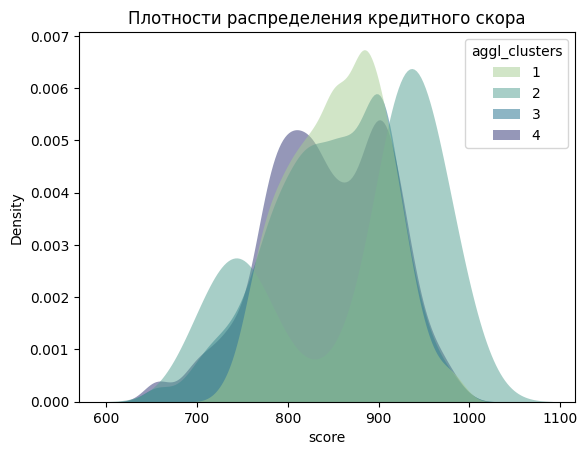

In [36]:
sns.kdeplot(data=subset, x='score', hue='aggl_clusters', fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,)
plt.title('Плотности распределения кредитного скора')
plt.show()

На графике мы видим, что различие вызвано 2 группой, которая отличается бОльшим разбросом дохода и смещением среднего значения. Проверим это различие пост хок сравнением.

In [37]:
pg.pairwise_gameshowell(data=df_balanced, dv='score',
                        between='cluster', effsize='hedges').round(3)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,второй,первый,878.642,860.552,18.090,6.488,2.788,444.528,0.028,0.236
1,второй,третий,878.642,848.276,30.366,6.928,4.383,505.525,0.000,0.371
2,второй,четвертый,878.642,830.588,48.054,7.160,6.711,527.572,0.000,0.567
3,первый,третий,860.552,848.276,12.276,5.189,2.366,530.440,0.085,0.200
4,первый,четвертый,860.552,830.588,29.964,5.494,5.454,508.973,0.000,0.461
5,третий,четвертый,848.276,830.588,17.688,6.008,2.944,551.484,0.018,0.249


Судя по данным этой таблицы, мы можем достоверно (со средним размером эффекта) сказать, что существуют значимые различия между кластерами: **второй** - **четвертый**, **первый** - **четвертый**. Это означает, что клиенты четвертого кластера имеют в среднем скор ниже, чем остальные группы.

<a class="anchor" id="hypothesis_3"></a>
### Гипотеза №3:
**H0:** Доля отточных пользователей для клиентов всех кластеров одинакова, т.е. отток и деление на кластеры не связаны.  
**H1:** Существует значимая разница между долями оттока среди групп.  

Для данной проверки подойдёт тест хи-квадрат на независимость двух категориальных значений. Он является параметрическим и применим для больших выборок

In [38]:
from scipy.stats import PermutationMethod

churn_groups = np.array([[group['churn'].sum() for _, group in subset.groupby('aggl_clusters')], \
                [group['churn'].count() for _, group in subset.groupby('aggl_clusters')]])


chi2, p, dof, expected = chi2_contingency(churn_groups)
print(f"Chi2 статистика: {chi2}")
print(f"P-Value: {p}")
print()
cramers_v = math.sqrt(chi2/(min(churn_groups.shape[0] - 1, churn_groups.shape[1] - 1) * len(subset)))
print(f"Мера Крамера V: {cramers_v}")

Chi2 статистика: 253.4105665305189
P-Value: 1.1971562532436766e-54

Мера Крамера V: 0.16041254900538057


Итого мы получили статистически значимый результат (p-value < 0.05), который оказывается слабым на практике. Связь между переменными есть, но незначительная. Т.е. различия в доле оттока несильно связаны с кластерами.

<a class="anchor" id="hypothesis_4"></a>
### Гипотеза №4:
**H0:** Отношение долей клиентов при фиксированных кол-вах продуктов и собственности в разрезе оттока одинакова.  
**H1:** Существует значимая разница между количеством продуктов, собственности по признаку оттока.  

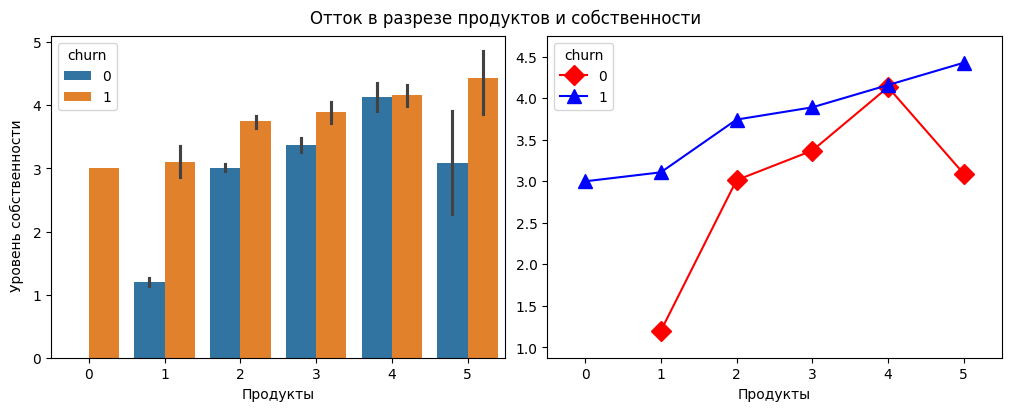

In [39]:
from statsmodels.graphics.factorplots import interaction_plot

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
fig.suptitle("Отток в разрезе продуктов и собственности")
sns.barplot(subset, x="products", y="equity", hue="churn", ax=axes[0])
interaction_plot(subset.products , subset.churn , subset.equity,
             colors=['red','blue'], markers=['D','^'], ms=10, ax=axes[1], xlabel='Продукты')

axes[0].set(xlabel="Продукты", ylabel=None)
axes[1].set(ylabel=None)
fig.supylabel("Уровень собственности", fontsize=10)
plt.show()

По приведенным графикам заметно различие в уровне оттока при группировке по продуктам - совпадают по оттоку лишь клиенты с 4 продуктами. По группам собственности также видна разница - клиенты оттока, как правило, имеют больше объектов в собственности (3-4), чем неотточные (1-3).  
Проверим связь между переменными с помощью построения логлинейной модели.

In [40]:
%load_ext rpy2.ipython

C:\Users\Dia\venvs\final_project\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning:

The symbol 'quartz' is not in this R namespace/package.



In [41]:
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro

with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(subset)

In [42]:
%%R -i r_df
library(MASS)
library(caret)
set.seed(42)
trainIndex <- createDataPartition(r_df$churn, p = 0.8, list = FALSE, times = 1)

trainData <- r_df[trainIndex, ]
testData <- r_df[-trainIndex, ]
mytable <- xtabs(~equity + products + churn, data=trainData)
df <- as.data.frame(mytable)
df <- subset(df, !(equity %in% c(6, 7, 8, 9)) & (products != 0))

Loading required package: ggplot2
Loading required package: lattice


In [46]:
%%R
library(broom)
library(vcd)
library(vcdExtra)
library(knitr)
library(glmulti)
library(mcprofile)
library(car)

# Выбираем модель с наилучшим AIC для определения связи между категориальными данными
search_best <- glmulti(y = Freq ~ equity*products*churn, data = mytable, fitfunction = "glm", level = 2, method = "h", crit = "aicc", family = poisson(link="log"))
print(head(weightable(search_best)))


wrap_confint <- function(mc_obj, adjust = "none", method = "profile", digits = 3) {
    ci <- exp(confint(mc_obj, adjust = adjust))
    parameter_names <- dimnames(ci$CM)[[1]]

    estimates <- ci$estimate$Estimate

    lower_bounds <- round(ci$confint$lower, digits)
    upper_bounds <- round(ci$confint$upper, digits)

    ci_df <- data.frame(
      Parameter = parameter_names,
      Estimate = estimates,
      Lower_Bound = lower_bounds,
      Upper_Bound = upper_bounds
    )
    
    colnames(ci_df) <- c("Lower Bound", "Upper Bound")
    ci_df[is.na(ci_df)] <- "-"
    return(ci_df)
}

# Обучаем выбранную лучшую модель
mod_fit <- glm(formula = Freq ~ 1 + equity + products + churn + products:equity + churn:equity + churn:products, family = quasipoisson(link = "log"), data = df)
tidy(Anova(mod_fit))

# Создаем матрицы контрастов для определения доверительных интервалов эффектов

contr_mat_EC <- rbind(
    c(rep(0, 31), -1, rep(0, 8)), # e0:e1
    c(rep(0, 31), 1, -1, rep(0, 7)), #e2:e1
    c(rep(0, 32), 1, -1, rep(0, 6)), #e3:e2
    c(rep(0, 33), 1, -1, rep(0, 5)), #e4:e3
    c(rep(0, 34), 1, -1, rep(0, 4)), #e4:e5
    c(rep(0, 32), -1, rep(0, 7)), #e0:e2
    c(rep(0, 33), -1, rep(0, 6)), #e0:e3
    c(rep(0, 34), -1, rep(0, 5)), #e0:e4
    c(rep(0, 35), -1, rep(0, 4)), #e0:e5
    c(rep(0, 31), 1, 0, -1, rep(0, 6)), #e1:e3
    c(rep(0, 31), 1, 0, 0, -1, rep(0, 5)), #e1:e4
    c(rep(0, 31), 1, 0, 0, 0, -1, rep(0, 4)), #e1:e5
    c(rep(0, 32), 1, 0, -1, rep(0, 5)), #e2:e4
    c(rep(0, 32), 1, 0, 0, -1, rep(0, 4)), #e2:e5
    c(rep(0, 33), 1, 0, -1, rep(0, 4))) #e3:e5
row.names(contr_mat_EC) <- c("EC 1:0 | yes:no", "EC 2:1 | yes:no", "EC 3:2 | yes:no", "EC 4:3 | yes:no",
                             "EC 5:4 | yes:no", "EC 2:0 | yes:no", "EC 3:0 | yes:no", "EC 4:0 | yes:no",
                             "EC 5:0 | yes:no", "EC 3:1 | yes:no", "EC 4:1 | yes:no", "EC 5:1 | yes:no",
                             "EC 4:2 | yes:no", "EC 5:2 | yes:no", "EC 5:3 | yes:no")


contr_mat_PC <- rbind(
    c(rep(0, 36), -1, rep(0, 3)), # p1:p2
    c(rep(0, 36), 1, -1, rep(0, 2)), #p2:p3
    c(rep(0, 37), 1, -1, rep(0, 1)), #p3:p4
    c(rep(0, 38), 1, -1), #p4:p5
    c(rep(0, 37), -1, rep(0, 2)), #p1:p3
    c(rep(0, 38), -1, rep(0, 1)), #p1:p4
    c(rep(0, 39), -1), #p1:p5
    c(rep(0, 36), 1, 0, -1, rep(0, 1)), #p2:p4
    c(rep(0, 36), 1, 0, 0, -1), #p2:p5
    c(rep(0, 37), 1, 0, -1)) #p3:p5
row.names(contr_mat_PC) <- c("PC 2:1 | yes:no", "PC 3:2 | yes:no", "PC 4:3 | yes:no", "PC 5:4 | yes:no",
                             "PC 3:1 | yes:no", "PC 4:1 | yes:no", "PC 5:1 | yes:no",
                             "PC 4:2 | yes:no", "PC 5:2 | yes:no", "PC 5:3 | yes:no")

LRCI_EC <- mcprofile(mod_fit, CM = contr_mat_EC)
LRCI_PC <- mcprofile(mod_fit, CM = contr_mat_PC)

# готовые таблицы доверительных интервалов
ci_df_EC <- wrap_confint(LRCI_EC, adjust = "bonferroni", method="profile")
ci_df_PC <- wrap_confint(LRCI_PC, adjust = "bonferroni", method="profile")

# коэффициенты линейной части модели
coeffs <- as.data.frame(round(summary(mod_fit)$coefficients, 3))

Initialization...
TASK: Exhaustive screening of candidate set.
Fitting...
Completed.
                                                                                   model
 Freq ~ 1 + equity + products + churn + products:equity + churn:equity + churn:products
                Freq ~ 1 + equity + products + churn + products:equity + churn:products
                  Freq ~ 1 + equity + products + churn + products:equity + churn:equity
                                 Freq ~ 1 + equity + products + churn + products:equity
                   Freq ~ 1 + equity + products + churn + churn:equity + churn:products
                                  Freq ~ 1 + equity + products + churn + churn:products
       aicc       weights
  860.3043  1.000000e+00
 1057.0658  1.878427e-43
 1123.8548  5.898352e-58
 1696.1419 3.163575e-182
 2648.7036  0.000000e+00
 3281.9637  0.000000e+00


In addition: Warning message:
glm.fit: fitted rates numerically 0 occurred 


Для выполнения логлинейного анализа использованы функции glmulti() и glm() в R. Первая отвечает за поиск оптимальной модели для текущего набора параметров. Её вывод - это наилучшие из подобранных моделей, где каждое сочетание вида **A:B** означает взаимосвязь переменных. Ниже представлена таблица с AIC скором. Как мы видим, самой удачной оказалась модель, содержащая в себе все попарные связи. Это значит, что связь между отточностью и кол-вом собственности и продуктов подтверждается. Далее рассмотрим коэффициенты:

In [44]:
ci_df_EC = %R ci_df_EC
ci_df_PC = %R ci_df_PC
coeffs = %R coeffs
coeffs['signif'] = coeffs['Pr(>|t|)'].apply(
    lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else ('.' if x < 0.1 else ' '))))
ci_df_EC.columns = ['Odds Ratio', 'Estimate', 'Lower', 'Upper']
ci_df_EC.set_index('Odds Ratio', inplace=True)
ci_df_PC.columns = ['Odds Ratio', 'Estimate', 'Lower', 'Upper']
ci_df_PC.set_index('Odds Ratio', inplace=True)
print('\033[1m' + 'Отношение шансов (частот) продуктов по уровням оттока' + '\033[0m')
display(ci_df_PC)

Отношение шансов (частот) продуктов по уровням оттока


,Estimate,Lower,Upper
Odds Ratio,,,
PC 2:1 | yes:no,0.623933,-,-
PC 3:2 | yes:no,0.580951,0.389,-
PC 4:3 | yes:no,0.256335,-,-
PC 5:4 | yes:no,2.228139,-,-
PC 3:1 | yes:no,0.362475,0.211,-
PC 4:1 | yes:no,0.092915,0.047,-
PC 5:1 | yes:no,0.207028,0.013,-
PC 4:2 | yes:no,0.148918,0.084,0.26
PC 5:2 | yes:no,0.331810,0.02,-


Столбцы lower и upper означают границы 95% доверительного интервала. В данном случае 0 не входит ни в один из них, что говорит о том, что все коэффициенты скорее отклоняются от нуля и значимы. Теперь о результатах:  
Например, первая строка трактуется как $$ \Large \frac{(\frac{\mu_{2 продуктов}}{\mu_{1 продукта}})_{churn=0}}{(\frac{\mu_{2 продуктов}}{\mu_{1 продукта}})_{churn=1}} = 0.624$$

То есть отношение клиентов с 2 продуктами к 1 продукту в группе лояльных клиентов в 1,6 раза меньше. Далее, тренд сохраняется, и, как мы видим на графике, единственное исключение - в лояльной группе больше клиентов с 5 продуктами, чем в отточной. Но по большому счёту тенденция такова: отточные клиенты обычно пользуются большим кол-вом продуктов по сравнению с лояльными.  

In [45]:
display(ci_df_EC)

,Estimate,Lower,Upper
Odds Ratio,,,
EC 1:0 | yes:no,0.387368,0.159,-
EC 2:1 | yes:no,0.776123,0.339,-
EC 3:2 | yes:no,0.691318,0.378,-
EC 4:3 | yes:no,0.843963,0.532,-
EC 5:4 | yes:no,0.785058,0.52,1.181
EC 2:0 | yes:no,0.300645,0.133,-
EC 3:0 | yes:no,0.207841,0.098,0.415
EC 4:0 | yes:no,0.175410,-,-
EC 5:0 | yes:no,0.137707,0.066,-


Такая же интерпретация у следующей таблицы. По уровням собственности наиболее близки к "1" 4 и 3 балла, что означает равную долю 3 и 4 балльных клиентов как в отточной, так и в лояльной категориях. Остальные коэффициенты неизменно говорят о том, что шансы примерно 3:2 что случайный отточный клиент имеет больше собственности, чем лояльный.

Приведенный выше сравнительный анализ показал значимую разницу между отточными и лояльными клиентами на уровне собственности и продуктов. Таким образом, мы отвергаем нулевую гипотезу о независимости этих величин с оттоком. 

<a class="anchor" id="segmentation"></a>
## Сегментация клиентов

### Клиенты были поделены на 4 группы в соответствии со степенью выраженности тех или иных параметров. Общие портреты таковы:

<dl>
<dt><span style="color:red; font-weight: bold;">Группа A</span></dt>
<dd>Клиенты более старшего сегмента, отличительные черты - большее кол-во имущества, отсутствие текущих кредитных обязательств, в среднем >=2 продукта используется. По уровню дохода не выделяются, однако имеют накопленную собственность. Среди них наблюдаемый процент оттока наиболее высок.</dd>
<dt><span style="color:red; font-weight: bold;">Группа B</span></dt>
<dd>Немногочисленная когорта "сверхвысокого" дохода. Вторая по распределению возраста, отличается также наименьшим баллом собственности, и использованием в среднем одного продукта из предложений (низкая конверсия в покупателя). При этом кредитный рейтинг значительно выше остальных групп. Показатель оттока в целом невысок.</dd>
<dt><span style="color:red; font-weight: bold;">Группа C</span></dt>
<dd>Группа среднего класса. Характерно наличие активного кредита, а также 0 активность за последний наблюдаемый горизонт. Баллов в собственности в среднем 2. Отличается минимальным процентом оттока.</dd>
<dt><span style="color:red; font-weight: bold;">Группа D</span></dt>
<dd>Активные клиенты-пользователи несколькими продуктами банка, сосредоточенная на накоплении недвижимости и сохранении подушки безопасности. Имеют открытый кредит, однако не отличаются большим кредитным скором. Отток равен среднему по всем клиентам.</dd>
</dl>

Основные выводы по результату анализа:  
    1. Половина клиентов имеет <= 3 баллов собственности, при этом только 5% имеют балл выше 5. Сравнение кредитного скоринга по баллам собственности показало, что **люди с 1-3 баллами имеют рейтинг значимо ниже остальных**. При этом проверка Гипотезы №2 показала, что кредитный рейтинг между кластерами различается. Наименьший показатель у группы D.  
    2. Между оцениваемым доходом и оттоком найдена статистически значимая связь по результатам проверки, НО на практике она незначительна и является скорее результатом перевеса между долями оттока/не оттока.  
    3. Гипотеза №3 показала, что хоть мы и видим разницу в средних долях оттока по кластерам, её не стоит воспринимать всерьёз. В целом группы на 85% сбалансированны по оттоку. Пристального рассмотрения заслуживает только группа A.  
    4. Наконец, между оттоком и продуктами, оттоком и собственностью существует попарная взаимосвязь. Самые интересные выводы даёт Гипотеза №4. Благодаря анализу пропорций по уровням продуктов/собственности выяснилось, что **отточные клиенты в среднем имеют больше собственности и больше продуктов банка**. Это соответствует группам A и D.  

<a class="anchor" id="recommendations"></a>
## Рекомендации

<a class="anchor" id="prioritization"></a>
### Приоритизация групп:  
1. Группа A - рассматриваем в первую очередь, поскольку это финансово ёмкие клиенты. Они имеют накопленный капитал и пользуются продуктами.  
2. Группа D - активные пользователи, сберегатели. По основным признакам должны быть лояльны, однако % оттока немал.  
3. Группа B - категория финансово устойчивых клиентов с высоким потенциалом платёжеспособности. Их нужно стимулировать к продуктам банка.  
4. Группа C - "стабилизированная" группа. Для них спец. предложения не требуются.

<a class="anchor" id="solutions"></a>
### Решения:
| Приоритет  | Группа     |                |
|----|---------|------------------|
| 1  | A | Составить программы лояльности. Упрощение условий по кредитам и депозитам при пользовании 2 и более продуктами банка. Персональные звонки и e-mail рассылки с полезными предложениями. |
| 2  | D | Активно запускаем акции: Повышенный кэшбек и бонусы на категории, связанные с их целями - ЖКХ и коммунальные услуги, страховые взносы. Стимулируем бонусами: например, +0.5% к ставке при поддержании определённого баланса, или частичное снятие без процентов. Очень важный момент - бонусы за вовремя внесенные платежи, которые со временем уменьшают ставку по текущему кредиту. |
| 3  | C | Главная задача - увеличить конверсию и вовлеченность, такие клиенты ценят статусность и удобство. Поэтому предлагаем эксклюзивные решения: VIP-статус за активное использование банковских услуг (элитные кредитные карты, выделенный персональный менеджер, инвестиционные портфели с низкими рисками, доступ в закрытые мероприятия, бонусные программы в travel-секторе, выгодные условия на покупку недвижимости или страхование активов) |
| 4  | B | Повышаем уровень активности за счет программы лояльности - например, уровневая система привилегий (чем активнее клиент, тем выше уровень), индивидуальные бонусы - например, за открытие нового счёта, или баллы за каждую операцию. Можно рассылать образовательный контент и финансовые советы ("Как гасить кредит и копить?")  |

Приведённые выше предложения лимитируются ресурсами отдела маркетинга, поэтому стоит разделить фокус внимания на доли процентов, соответствующих позиции категорий в пирамиде приоритетности.

# Декомпозиция проекта

`Шаг 1.` Загрузка данных  
`Шаг 2.` Предобработка данных  
  - Этап 1. Применение общей функции на выявление:  
      - явных и неявных дубликатов  
      - списка уникальных значений категориальных данных (проверка качества нахождения неявных дубликатов)   
      - общей информации о датафрейме (типы данных по столбцам, наименования колонок)  
  - Этап 2. Исследовать и заменить пропуски  
  - Этап 3. Удалить дубликаты  
  - Этап 4. Привести типы  
  
`Шаг 3.` Исследовательский анализ данных  
  - Этап 1. Изучение диапазонов параметров и определение превалирующих значений  
  - Этап 2. Рассмотрение конкретных столбцов  
  - Этап 3. Визуализация взаимосвязей между переменными, где это возможно/релевантно  
  
`Шаг 4.` Проверить влияние баланса на счёте на вероятность оттока  
`Шаг 5.` Проверить, как количество продуктов клиента влияет на вероятность оттока  
`Шаг 6.` Проверить, есть ли взаимосвязь между потенциалом успешного погашения кредита и вероятностью оттока  
(К Шагам 4-6 применим общий алгоритм: )  
  - Этап 1. Разделить клиентов по параметру на когорты  
  - Этап 2. Внутри каждой категории посчитать процент ушедших  
  - Этап 3. Внутри каждой категории определить дополнительные факторы влияния  
  - Этап 4. Сделать промежуточные выводы, как доп. факторы сказываются на параметре  
  - Этап 5. Сделать вывод, как рассматриваемый параметр влияет на отток  
  
`Шаг 7.` Проверить гипотезу различия дохода между ушедшими и оставшимися клиентами  
`Шаг 8.` Проверить гипотезу различия кредитного скоринга между ушедшими и оставшимися клиентами  
`Шаг 9.` Проверить гипотезу о различиях в категориальных параметрах (пол, город) между ушедшими и оставшимися  
`Шаг 10.` На основе проведенного анализа выделить группы клиентов по объединённым признакам, обосновать  
`Шаг 11.` Составить рекомендации для этих групп, опираясь на тренды в их показателях
`Шаг 12.` Сделать общий вывод исследования, дополнив презентацией с историей


<div class="alert alert-warning">
<h2> Комментарий тимлида 🤓<a class="tocSkip"> </h2>
    
Далее рассмотрю и прокомментирую каждый блок)

`Шаг 1.` Загрузка данных  
`Шаг 2.` Предобработка данных  
  - Этап 1. Применение общей функции на выявление:  
      - явных и неявных дубликатов  
      - списка уникальных значений категориальных данных (проверка качества нахождения неявных дубликатов)   
      - общей информации о датафрейме (типы данных по столбцам, наименования колонок)  
  - Этап 2. Исследовать и заменить пропуски
      - 2.1. Определить пропуски в соответствии с MCAR/MAR/MNAR
      - 2.2. Создать параметр и с помощью сводной таблицы определить, насколько выраженна зависимость пропусков от других параметров данных
  - Этап 3. Кодирование переменных (при необходимости)
  - Этап 4. Удалить дубликаты или выбрать вариант отдельной обработки
  - Этап 5. Привести типы  


<div class="alert alert-warning">
<h2> Комментарий тимлида 🤓<a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 
1. Проверка пропусков. В части пропусков здесь можно пользоваться общепринятой классификацией пропусков:
        
- MCAR (Missing Completely At Random / Отсутствует совершенно случайно) — пропуски не зависят от переменных и не ведут к систематической ошибке (смещение, bias), но увеличивают случайную ошибку (разброс, variance), можно их отбрасывать или заполнять, т.к. заполнение не повлияет на характер связи между заполняемой переменной и остальными;
- MAR (Missing At Random / Отсутствует случайно) — в рамках каждой из групп, которая есть в описываемой данными совокупности, распределение пропусков случайно, можно их отбрасывать;
- MNAR (Missing Not At Random / Отсутствует не случайно) — пропуски зависят от данных, без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям.
        
    Перед обработкой пропусков обязательно стоит выяснить, к какому типу они относятся, а также как эти пропуски зависят от имеющихся данных - тогда можно будет выбрать более удачную стратегию работы с ними.
        
    Тут будет проще создать новый признак, принимающий 1, если в наблюдении пропущено значение признака, и 0, если в наблюдении значение признака не пропущено. Далее этот признак использовать как столбец сводной таблицы, где по каждому признаку будет посчитана мера центральной тендеции (о том, как выбрать нужную меру - см.в разделе анализа портрета клиентов). Цель такого анализа - найти зависимости пропусков от данных или подтвердить отсутствие таких зависимостей.
        
        
2. Кодирование переменных. В зависимости от того, какой подход к работе с корреляцией будет выбран, может понадобиться кодирование категориальных переменных. Категориальные признаки делятся на `упорядоченные` (уровень образования, удовлетворённости пользователя) и `неупорядоченные` (город, брачный статус и т.п.). Центральные тенденции второго можно смотреть при помощи моды. Будет некорректно задавать неупорядоченным категориям какой-то числовой порядок и смотреть средние арифметические. К средним каких-то ординальных показателей, или численных показателей, содержащих большое число значений, например возраста, надо относиться так, что это центр распределения, которое может иметь какую-то сложную природу. Бинарные показатели, если к ним применить среднее, показывают нам долю тех клиентов, у которых этот бинарный показатель равен единице. Уже на этапе подготовки данных важно закодировать данные численно. Для того, чтобы применять среднее и смотреть корреляции какого-то числового показателя с категориальным неупорядоченным, можно применить <a href='https://habr.com/ru/post/666234/'>one-hot кодирование</a>, проще всего это сделать при помощи `pandas.get_dummies()`. Чтобы при этом не потерять оригинальный столбец, стоит сделать его копию и использовать параметр <tt>columns</tt> (чтобы перекодированию подвергся или подверглись только те столбцы, которые нам нужно перекодировать).
        
        
3. Неявные дубликаты. Обязательно стоит проверить неявные дубликаты по `user_id`, при этом удаление - не всегда лучшее решение: нужно посмотреть, что из себя представляют клиенты с дублированным `user_id` и уже после этого принимать решение о дальнейшей работе с ними. Посмотреть на полный набор дублированных строк можно с помощью метода `duplicated()` с параметром `keep=False`.
    
4. Также важно помнить, что в нашем датасете только актуальные данные, т.е. все клиенты на данный момент являются действующими, а значит  у них есть минимум один продукт)

<div class="alert alert-info"> <b>Комментарий студента:</b> 
Спасибо за разъяснение, учла.  
    
Не понятна пара моментов:  
    
> (о том, как выбрать нужную меру - см.в разделе анализа портрета клиентов). 
    
 - Где находится раздел анализа портрета клиентов?  
 - Обязательно ли рассчитывать меру центр. тенденции для каждого категориального столбца, или для каких-то можно опустить?
 - столбцы с on-hot кодированием лучше помещать в отдельную табличку по каждому признаку?
</div>

<div class="alert alert-warning">
<h2> Комментарий тимлида 🤓 v_2<a class="tocSkip"> </h2>
  
1) Привет, раздел Исследовательского анализа Этап 6 , ниже добавлю комментарий)
    
2) Нет, для города например можно опустить)
    
3) Удобнее в исходную добавить, чтобы корреляцию в общей таблице отобразить

  
`Шаг 3.` Исследовательский анализ данных  
  - Этап 1. Изучение диапазонов параметров и определение превалирующих значений  
  - Этап 2. Рассмотрение конкретных столбцов  
  - Этап 3. Визуализация взаимосвязей между переменными, где это возможно/релевантно
  - Этап 4. Изучение распределения характеристик в разрезе оттока
  - Этап 5. Рассчёт зависимости данных с целевой характеристикой, визуализация матрицы корреляций, выводы
  - Этап 6. Оценочное сравнение количественных портретов отточных/неотточных клиентов


<div class="alert alert-warning">
<h2> Комментарий тимлида 🤓 v_2<a class="tocSkip"> </h2>
  
По обычным гистограммам или sns.countplot графикам можно делать грубые выводы, но из-за необходимости делать поправки на разные размеры групп в уме, точных выводов по ним обычно не сделаешь. Нивелировать разницы в размерах групп можно если применить <tt>sns.kdeplot</tt> или <tt>sns.hisplot</tt> с параметрами <tt>hue</tt> и настройками <tt>stat="density", common_norm=False</tt> (для kdeplot stat="density" не нужно, common_norm=False нужно именно при использовании hue). При использовании plt.hist и основанных на нём методах pandas достаточно установить параметр <tt>density=True</tt>, также понадобится установить прозрачность (цвета лучше подобрать так, чтобы было меньше затруднений от того, что они смешаются). Обращаю внимание, что метод <tt>sns.dis<b>t</b>plot</tt> является устаревшим и его нежелательно использовать.

В px.histogram, если хочется использовать именно эту библиотеку, можно установить параметры <tt>histnorm='probability density',barmode ='overlay'</tt>. Если категорий больше двух, то для облегчения восприятия можно передать в метод графика параметр <tt>barnorm='percent'</tt> и <tt>barmode='stack'</tt>.

В целом гистограммы подходят для непрерывных переменных и переменных с большим числом уникальных значений. Если гистограмма "идёт лесенкой", это означает, что для дискретной переменной выбрано некратное количество корзин. Можно использовать параметр <tt>binwidth</tt>, но только для дискретных величин, не достигающих огромных значений (может приводить к зависанию ядра). Для анализа бинарных и категориальных признаков гистограммы не подходят.

Для категориальных есть очень простой и действенный, а главное понятный и больше подходящий для презентации подход — можно делать сводные таблицы pivot_table с уровнем оттока по категориям (или сделать группировку по категории с последующей аггрегацией информации об оттоке) и из них столбиковые диаграммы со средним уровнем оттока по банку.
</div>

<div class="alert alert-warning">
<h2> Комментарий тимлида 🤓 v_2<a class="tocSkip"> </h2>
Портрет клиента. Будет здорово, если меры центральной тендецнии, описывающие портреты клиентов, будут собраны в виде таблицы, и по каждому признаку между сегментами будет посчитана относительная разница.
        
   Обращу внимание, что среднее нужно использовать для непрерывных величин - в таком виде бизнесу удобнее работать с цифрами. Также если у непрерывной величины есть выбросы, в дополнение к среднему нужно считать медиану, чтобы понимать, в какой сторону смещено распределение.
        
   Что касается дискретных признаков - тут лучше использовать медиану, чтобы не было непонятных значений вроде `male=0.475, female=0.354` - бизнесу будет не слишком очевидно, как такие вещи интерпретировать.
        
   При работе с незакодированными категориальными переменными нужно использовать моду.
        
   Закодированные признаки в портрете клиента лучше не использовать - их значения менее интерпретируемы относительно моды по исходным категориальным признакам.
        
  Относительную разницу для моды и медианы считать не нужно.  

<div class="alert alert-warning">
<h2> Комментарий тимлида 🤓 v_2<a class="tocSkip"> </h2>
  Коррелляция. Исследовать нужно корреляцию всех признаков таблицы. Корреляцию можно анализировать попарно между всеми признаками, если хочется копнуть глубже, но важно сделать фокус на анализе корреляции признаков с признаком оттока.
        
  Напомню, что корреляцию важно не только посчитать, но и прокомментировать - за основу стоит взять шкалу корреляции Чеддока.
    
  При оформлении матрицы корреляций в виде графика рекомендую использовать `sns.heatmap()`, одна из наиболее удачных цветовых схем с нейтральным нулём и градиентами по мере усиления взаимосвязи - `cmap='coolwarm'`, также стоит задать центрирование на ноль (`center=0`), чтобы цветовая окраска работала корректно.
        
  Более интересным решением, чем `df.corr()`, которое считает стандартную корреляцию Пирсона, будет использование `phik` - эта библиотека работает сразу со всеми признаками, считая нужный тип корреляции в зависимости от принадлежности признака к той или иной категории. Плюс библиотеки в том, что она улавливает также нелинейные зависимости, минус - не показывает направление зависимости. Также при использовании `phik` важно настроить параметр `interval_cols`, передав ему список непрерывных признаков: важность этого действия в том, что без явного указания категориальных признаков библиотека пытается определять их самостоятельно и часто делает это плохо, а от принадлежности переменной к определённому типу зависит способ оценки корреляции, поэтому важно про это не забыть.

<div class="alert alert-block alert-danger">
<h2> Комментарий тимлида ⛔️<a class="tocSkip"></h2>
<s>

Необходимо будет <b>изучить распределения характеристик в разрезе оттока</b> (это подразумевается выше, но прямо не говорится). Для непрерывных характеристик построить гистограммы или kde-графики, для категориальных (возможно, включая те, которые мы образовали изучив непрерывные) — столбчатые диаграммы с уровнями оттока (количество отточных в категории, делённое на общее количество в категории), либо, если мы исследуем продукты, то тепловую карту с долями пользующихся N продуктами в каждой из категорий.

<div class="alert alert-block alert-danger">
<h2> Комментарий тимлида ⛔️<a class="tocSkip"></h2>
<s>
Необходимо будет проанализировать все данные на предмет наличия корреляций с целевой характеристикой, описать всё, что превосходит по модулю 10%, указывая размер корреляции (это будет использоваться в дальнейшем в промежуточном итоге перед сегментацией), подготовить читаемый график (тепловую карту) для презентации.

<div class="alert alert-block alert-danger">
<h2> Комментарий тимлида ⛔️<a class="tocSkip"></h2><s>
Нужно будет сравнить количественные портреты клиентов, т.е. показатели типичных клиентов (как анализ стат.гипотез на равенство средних, только без стат.методов, на глаз). Это значит взять подходящие средние тенденции и посчитать для каждой характеристики, на сколько процентов это число больше (меньше) у отточных по сравнению с неотточными.

<div class="alert alert-info"> <b>Комментарий студента:</b>  
    
Добавила все нужные этапы в соответствии с поправками.
</div>

  
`Шаг 4.` Проверить влияние **баланса на счёте** на вероятность оттока  
`Шаг 5.` Проверить, как **количество продуктов клиента** влияет на вероятность оттока  
`Шаг 6.` Проверить, есть ли взаимосвязь между **потенциалом успешного погашения кредита** и вероятностью оттока  
(К Шагам 4-6 применим общий алгоритм: )  
  - Этап 1. Разделить клиентов по **параметру** на когорты  
  - Этап 2. Внутри каждой категории посчитать процент ушедших  
  - Этап 3. Внутри каждой категории определить дополнительные факторы влияния  
  - Этап 4. Сделать промежуточные выводы, как доп. факторы сказываются на **параметре**
  - Этап 5. Сделать вывод, как рассматриваемый **параметр** влияет на отток  


<div class="alert alert-warning">
<h2> Комментарий тимлида 🤓<a class="tocSkip"> </h2>
  
Смотри данные шаги идут как дополнительное исследование? Почему мы их выносим за пределы исследовательского анализа? Не будут ли шаги 4 и 5 входить в исследовательский?
    
Дополнительные вопросы для уточнения: По какому точно параметру будем объединять и делить на когорты? Как именно будем делить? 
    
Давай уточним, чтобы путанницы не было.

<div class="alert alert-info"> <b>Комментарий студента:</b>  
    
Данные шаги относятся к замечанию "изучить данные на наличие корреляций с цел. х.", я выделила их отдельными шагами, чтобы акцентировать, что эти взаимосвязи являются приоритетными и связаны с изначальными собственными гипотезами причин оттока.  
    
Также под "параметром" подразумевается каждая из выделенных величин в отдельности, просто шаги одинаковые, поэтому нет смысла дублировать алгоритм для каждого параметра
</div>

<div class="alert alert-success">
<h2> Комментарий тимлида 😊  v_2<a class="tocSkip"> </h2>

Хорошо, но вероятнее всего мы их изучим на этапе исследовательского анализа)

<div class="alert alert-warning">
<h2> Комментарий тимлида 🤓<a class="tocSkip"> </h2>

Категоризиация непрерывных признаков. Часто студенты любят делать категоризацию непрерывных признаков (10-20 лет, 100-1000 у.е.), но не до конца понимают смысл этой операции. Отмечу, что сама по себе категоризация не несёт большой ценности, потому что фильтрации вида `age = 'A'` и `10 < age < 20` дадут один и тот же результат, но наличие категорий будет утяжелять матрицу признаков. Если есть большое желание её делать - категории нужно выбирать согласно влиянию признака на отток, а не эмпирически на глазок.
        

 `Шаг 7.` Провести статистический анализ
   - Этап 1. Проверить гипотезу различия дохода между ушедшими и оставшимися клиентами  
   - Этап 2. Проверить гипотезу различия кредитного скоринга между ушедшими и оставшимися клиентами  


<div class="alert alert-block alert-danger">
<h2> Комментарий тимлида ⛔️<a class="tocSkip"></h2>
<s>
  Давай объединим в блок статистического анализа все гипотезы.

<div class="alert alert-warning">
<h2> Комментарий тимлида 🤓<a class="tocSkip"> </h2>
  
Так как тут можно самостоятельно выбирать инструментарий, то при проверках статистических гипотез необходимо обосновать выбор статистического критерия — перечислить все требования к данным, которые предъявляет этот критерий и проверить, соответствуют ли наши данные этим требованиям. Первую гипотезу, о том, влияет ли отток на доходы клиентов, необходимо проверить и t-критерием и u-критерием, объяснить расхождения, если они возникнут, выбрать, какому критерию стоит доверять сильнее. Т.к. необходимо понимать, когда следует применять t-критерий Стьюдента, а когда u-критерий Манна-Уитни, стоит описать, из-за чего между результатами работы критериев могут возникать расхождения, даже если они не возникли в данном случае.
    
Для гипотез, связанных с проверкой бинарных признаков, `ttest` или другие тесты, оценивающие среднее, не подойдут - тут нужен тест пропорций.
    
Также желательно, чтобы вторая, сформулированная вами гипотеза обоснованно требовала бы другого статистического критерия, либо проверка гипотезы была бы важна для выводов (касалась бы какой-то ситуации, когда на графиках видно небольшое различие и мы хотим подтвердить или опровергнуть свои выводы).
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b>  
    
Учту при выполнении, спасибо за рекомендацию
</div>

`Шаг 10.` Выполнить сегментацию клиентов, обосновать и составить приоритизацию


<div class="alert alert-warning">
<h2> Комментарий тимлида 🤓<a class="tocSkip"> </h2>
    
Можем указать как "Сегментация клиентов"
    
Удобно смотреть свойства сегментов кодом типа:
    
    df.query('<условие1> and <условие2>').agg({"churn":["mean","sum","count"], <столбец>:<методы>})
    
Так мы видим уровень оттока, количество отточных и общий размер сегмента. Можем также добавлять какие-то столбцы в аггрегацию, которые расскажут нам о ценности клиентов. По итогам нужно указать минимум три сегмента, которые стоит в первую очередь взять в работу.
    
Напомню, что не стоит выделять много сегментирующих признаков, чтобы сегменты не получились слишком узкими - так мы не сможем охватывать много клиентов в пределах сегмента, и это повышает риск того, что мероприятие по удержанию клиентов не окажется эффективным.
        
С другой стороны, слишком широкие сегменты в погоней за высоким уровнем оттока тоже не стоит делаать - к таким сегментам сложно подобрать рекомендации, и мы рисуем не удержать никого.
    
Важно отметить, что отдел маректинга включает только двух работников, у них нет автоматизированных систем, поэтому все мероприятия, рассылки и агитации будут выполнены ручным трудом. Поэтому важно приоритизировать сегменты, чтобы маркетинг знал, на что обратить внимание в первую очередь в случае, если ресурсов маркетинга не хватит на охват всех выделенных сегментов. Тут важно будет также пояснить, каким образом мы их приоритизируем. Наиболее очевидное решение - по мере убывания отточных клиентов, но если придумаешь свой алгоритм - будет круто)
    

`Шаг 11.` Составить рекомендации для этих групп, опираясь на тренды в их показателях  
`Шаг 12.` Сделать общий вывод исследования, дополнив презентацией с историей


<div class="alert alert-warning">
<h2> Комментарий тимлида 🤓<a class="tocSkip"> </h2>
  
Рекомендации должны относиться к конкретному сегменту, имеющему какой-то общий размер и уровень оттока (быть таргетированными), учитывать особенности этого сегмента, быть конкретными (содержать описание каких-то конкретных действий: акций, мероприятий, новых продуктов или изменения старых и т.п.) а не содержать указания для отдела маркетинга кого-то опросить и провести исследование и т.п.

<div class="alert alert-info"> <b>Комментарий студента:</b>  
Поняла. Индивидуальные конкретные шаги для реализации, сделаю.
</div>

<div style="border:solid Purple 2px; padding: 40px">
<h2> Общий комментарий тимлида 😊 v_2<a class="tocSkip"> </h2>

Можем приступать к проекту)

<div style="border:solid Purple 2px; padding: 40px">
<h2> Общий комментарий тимлида 😊<a class="tocSkip"> </h2>

Хорошая работа с декомпозицией, осталось немного дополнить)